In [1]:
import sqlite3
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm


In [2]:
pd.set_option('display.max_columns', None)

# Utility

In [3]:
def string_to_list(string):
    return  [i[1:-1]for i in string[1:-1].split(', ')]

In [4]:
def onehot(df, col):
    for i in range(len(df[col][0])):
        df[f'{col}_{i}'] = [data[i] for data in df[col]]
    df.drop(col, axis=1, inplace=True)
    return df

## Load Data from .db

In [5]:
def load_data():
    conn = sqlite3.connect("../Data/yelpResData.db")
    conn.text_factory = lambda x: str(x, 'gb2312', 'ignore')
    cursor = conn.cursor()
    
    # Create Review DataFrame
    cursor.execute(
        "SELECT reviewID, reviewerID, restaurantID, date, rating, usefulCount as reviewUsefulCount, reviewContent, flagged FROM review WHERE flagged in ('Y','N')")
    review_df = pd.DataFrame(cursor.fetchall(), columns=[column[0] for column in cursor.description])

    # Create Reviewer DataFrame
    cursor.execute("SELECT * FROM reviewer")
    reviewer_df = pd.DataFrame(cursor.fetchall(), columns=[column[0] for column in cursor.description])

    # Create Restaurant DataFrame
    cursor.execute("SELECT restaurantID, rating as restaurantRating FROM restaurant")
    restaurant_df = pd.DataFrame(cursor.fetchall(), columns=[column[0] for column in cursor.description])

    # Merge all DataFrames
    review_reviewer_df = review_df.merge(reviewer_df, on='reviewerID', how='inner')
    df = review_reviewer_df.merge(restaurant_df, on='restaurantID', how='inner')
    return df

## Cleaning data

In [6]:
def data_cleaning(df):
    # Removing \n from date field
    for i in range(len(df['date'])):
        if df['date'][i][0] == '\n':
            df['date'][i] = df['date'][i][1:]

    # Making yelpJoinDate Format Uniform
    df['yelpJoinDate'] = df['yelpJoinDate'].apply(
        lambda x: datetime.strftime(datetime.strptime(x, '%B %Y'), '01/%m/%Y'))

    # Pre-processing Text Reviews
    # Remove Stop Words
    stop = stopwords.words('english')
    df['reviewContent'] = df['reviewContent'].apply(
        lambda x: ' '.join(word for word in x.split() if word not in stop))

    # Remove Punctuations
    tokenizer = RegexpTokenizer(r'\w+')
    df['reviewContent'] = df['reviewContent'].apply(
        lambda x: ' '.join(word for word in tokenizer.tokenize(x)))

    # Lowercase Words
    df['reviewContent'] = df['reviewContent'].apply(
        lambda x: x.lower())
    return df

## Feature Engineering

In [7]:
def feature_engineering(df, N):
    mnr_df1 = df[['reviewerID', 'date']].copy()
    mnr_df2 = mnr_df1.groupby(by=['date', 'reviewerID']).size().reset_index(name='reviewPerDay')
    mnr_df2['scaledReviewPerDay'] = mnr_df2['reviewPerDay'] / mnr_df2['reviewPerDay'].max()
    mnr_df2.drop(columns=['reviewPerDay'], inplace=True)
    df = df.merge(mnr_df2, on=['reviewerID', 'date'], how='inner')

    # Review Length
    df['reviewsLength'] = df['reviewContent'].apply(
        lambda x: len(x.split()))

    # Review Deviation
    df['reviewsDeviation'] = abs(df['rating'] - df['restaurantRating']) / 4

    # Maximum cosine similarity
    review_data = df

    res = OrderedDict()

    # Iterate over data and create groups of reviewers
    for row in review_data.iterrows():
        if row[1].reviewerID in res:
            res[row[1].reviewerID].append(row[1].reviewContent)
        else:
            res[row[1].reviewerID] = [row[1].reviewContent]

    individual_reviewer = [{'reviewerID': k, 'reviewContent': v} for k, v in res.items()]
    df2 = dict()
    df2['reviewerID'] = pd.Series([])
    df2['maximumContentSimilarity'] = pd.Series([])
    vector = TfidfVectorizer(min_df=0)
    count = -1
    for reviewer_data in individual_reviewer:
        count = count + 1
        # Handle Null/single review gracefully -24-Apr-2019
        try:
            tfidf = vector.fit_transform(reviewer_data['reviewContent'])
        except:
            pass
        cosine = 1 - pairwise_distances(tfidf, metric='cosine')

        np.fill_diagonal(cosine, -np.inf)
        max = cosine.max()

        # To handle reviewier with just 1 review
        if max == -np.inf:
            max = 0
        df2['reviewerID'][count] = reviewer_data['reviewerID']
        df2['maximumContentSimilarity'][count] = max

    df3 = pd.DataFrame(df2, columns=['reviewerID', 'maximumContentSimilarity'])

    # left outer join on original datamatrix and cosine dataframe -24-Apr-2019
    df = pd.merge(review_data, df3, on="reviewerID", how="left")

    df.drop(index=np.where(pd.isnull(df))[0], axis=0, inplace=True)
  
    with open("../Data/top_word/top50_y_word.txt", "r") as f:
        fake_words = string_to_list(f.read())
  
    with open("../Data/top_word/top50_n_word.txt", "r") as f:
        non_fake_words = string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]

    # KL word count
    fakeWordsCount = []
    nonFakeWordsCount = []

    for content in df['reviewContent']:
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)
        fakeCount = 0
        nonFakeCount = 0
        for word in words:
            if word in fake_words:
                fakeCount += 1
            elif word in non_fake_words:
                nonFakeCount += 1
        fakeWordsCount.append(fakeCount)
        nonFakeWordsCount.append(nonFakeCount)
    
    df['fakeWordsCount'] = fakeWordsCount
    df['nonFakeWordsCount'] = nonFakeWordsCount
    
    # # KL one hot encoding
    # fakeWordOneHot = []
    # nonFakeWordOneHot = []

    # for content in df['reviewContent']:
    #     fakeOneHot = ''
    #     nonFakeOneHot = ''
    #     words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)

    #     for word in fake_words:
    #         if word in words:
    #             fakeOneHot += '1'
    #         else:
    #             fakeOneHot += '0'

    #     for word in non_fake_words:
    #         if word in words:
    #             nonFakeOneHot += '1'
    #         else:
    #             nonFakeOneHot += '0'
                
    #     fakeWordOneHot.append(fakeOneHot)
    #     nonFakeWordOneHot.append(nonFakeOneHot)
    
    # df['fakeWordsOneHot'] = fakeWordOneHot
    # # df['nonFakeWordsOneHot'] = nonFakeWordOneHot

    # df = onehot(df, 'fakeWordsOneHot')
    # # df = onehot(df, 'nonFakeWordsOneHot')
    
    return df
    

## Sampling

In [8]:
def under_sampling(df):
    print("Under-Sampling Data")

    sample_size = len(df[(df['flagged'] == 'Y')])

    authentic_reviews_df = df[df['flagged'] == 'N']
    fake_reviews_df = df[df['flagged'] == 'Y']

    authentic_reviews_us_df = authentic_reviews_df.sample(sample_size)
    under_sampled_df = pd.concat([authentic_reviews_us_df, fake_reviews_df], axis=0)

    print("Under-Sampling Complete")
    return under_sampled_df

In [9]:
def over_sampling(df):
    print("Over-Sampling Data")

    sample_size = len(df[(df['flagged'] == 'N')])

    authentic_reviews_df = df[df['flagged'] == 'N']
    fake_reviews_df = df[df['flagged'] == 'Y']

    fake_reviews_os_df = fake_reviews_df.sample(sample_size, replace=True)
    over_sampled_df = pd.concat([authentic_reviews_df, fake_reviews_os_df], axis=0)

    print("Over-Sampling Complete")
    return over_sampled_df

## Plot

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    return plt

## Learning

In [11]:
def supervised_learning(df, model, algorithm):
    df = df.copy()
    print("Training "+algorithm+" Model")
    labels = df['flagged']

    df.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged',
             'reviewContent', 'restaurantRating'], axis=1, inplace=True)

    train_data, test_data, train_label, test_label = train_test_split(df, labels, test_size=0.25, random_state=42)

    # param_grid = {
    #     'n_estimators': [10, 500],
    #     'max_features': ['auto', 'sqrt', 'log2'],
    #     'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    #     'criterion': ['gini', 'entropy']
    # }
    # grid_clf_acc = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    #
    # grid_clf_acc.fit(train_data, train_label)

    model.fit(train_data, train_label)
    predicted_labels = model.predict(test_data)

    # print('Best Params : ', grid_clf_acc.best_params_)
    print(algorithm + ' Model Results')
    print('--' * 20)
    print('Accuracy Score : ' + str(accuracy_score(test_label, predicted_labels)))
    print('Precision Score : ' + str(precision_score(test_label, predicted_labels, pos_label="Y")))
    print('Recall Score : ' + str(recall_score(test_label, predicted_labels, pos_label="Y")))
    print('F1 Score : ' + str(f1_score(test_label, predicted_labels, pos_label="Y")))
    print('Confusion Matrix : \n' + str(confusion_matrix(test_label, predicted_labels)))
    plot_confusion_matrix(test_label, predicted_labels, classes=['N', 'Y'],
                          title=algorithm + ' Confusion Matrix').show()

    return test_label, predicted_labels, model

In [12]:
def semi_supervised_learning(df, model, algorithm, threshold=0.8, iterations=40):
    df = df.copy()
    print("Training "+algorithm+" Model")
    labels = df['flagged']

    df.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged', 'restaurantRating'], axis=1, inplace=True)

    train_data, test_data, train_label, test_label = train_test_split(df, labels, test_size=0.25, random_state=42)

    test_review_content = test_data['reviewContent']
    train_data.drop(['reviewContent'], axis=1, inplace=True)
    test_data.drop(['reviewContent'], axis=1, inplace=True)
    
    test_data_copy = test_data.copy()
    test_label_copy = test_label.copy()

    all_labeled = False

    current_iteration = 0

    # param_grid = {
    #     'n_estimators': [10, 500],
    #     'max_features': ['auto', 'sqrt', 'log2'],
    #     'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
    #     'criterion': ['gini', 'entropy']
    # }
    # grid_clf_acc = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
    #
    # grid_clf_acc.fit(train_data, train_label)

    pbar = tqdm(total=iterations)

    while not all_labeled and (current_iteration < iterations):
        # print("Before train data length : ", len(train_data))
        # print("Before test data length : ", len(test_data))
        current_iteration += 1
        model.fit(train_data, train_label)

        probabilities = model.predict_proba(test_data)
        pseudo_labels = model.predict(test_data)

        indices = np.argwhere(probabilities > threshold)

        # print("rows above threshold : ", len(indices))
        for item in indices:
            train_data.loc[test_data.index[item[0]]] = test_data.iloc[item[0]]
            train_label.loc[test_data.index[item[0]]] = pseudo_labels[item[0]]
        test_data.drop(test_data.index[indices[:, 0]], inplace=True)
        test_label.drop(test_label.index[indices[:, 0]], inplace=True)
        # print("After train data length : ", len(train_data))
        # print("After test data length : ", len(test_data))
        print("--" * 20)

        if len(test_data) == 0:
            print("Exiting loop")
            all_labeled = True
        pbar.update(1)
    pbar.close()
    predicted_labels = model.predict(test_data_copy)

    # print('Best Params : ', grid_clf_acc.best_params_)
    print(algorithm + ' Model Results')
    print('--' * 20)
    print('Accuracy Score : ' + str(accuracy_score(test_label_copy, predicted_labels)))
    print('Precision Score : ' + str(precision_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('Recall Score : ' + str(recall_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('F1 Score : ' + str(f1_score(test_label_copy, predicted_labels, pos_label="Y")))
    print('Confusion Matrix : \n' + str(confusion_matrix(test_label_copy, predicted_labels)))
    plot_confusion_matrix(test_label_copy, predicted_labels, classes=['N', 'Y'],
                          title=algorithm + ' Confusion Matrix').show()

    results = test_data_copy.copy()
    results['reviewContent'] = test_review_content
    results['flagged'] = test_label_copy
    results['predicted'] = predicted_labels

    return model, results
                          

## Make train dataset

In [13]:
df = load_data()
df = data_cleaning(df)
df = feature_engineering(df, 100)

C:\Users\Um_25\AppData\Local\Temp\ipykernel_1840\3075169008.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'][i] = df['date'][i][1:]
C:\Users\Um_25\AppData\Local\Temp\ipykernel_1840\2252993440.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['reviewerID'] = pd.Series([])
C:\Users\Um_25\AppData\Local\Temp\ipykernel_1840\2252993440.py:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df2['maximumContentSimilarity'] = pd.Series([])


In [14]:
df.columns

Index(['reviewID', 'reviewerID', 'restaurantID', 'date', 'rating',
       'reviewUsefulCount', 'reviewContent', 'flagged', 'name', 'location',
       'yelpJoinDate', 'friendCount', 'reviewCount', 'firstCount',
       'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'tipCount',
       'fanCount', 'restaurantRating', 'scaledReviewPerDay', 'reviewsLength',
       'reviewsDeviation', 'maximumContentSimilarity', 'fakeWordsCount',
       'nonFakeWordsCount'],
      dtype='object')

In [15]:
under_sampled_df = under_sampling(df)
under_sampled_df.reset_index(drop=True, inplace=True)
# under_sampled_df.to_csv('../Data/under_sampled_KL_df.csv', index=False)
# under_sampled_df = pd.read_csv('../Data/under_sampled_KL_df.csv')

Under-Sampling Data
Under-Sampling Complete


In [16]:
over_sampled_df = over_sampling(df)
over_sampled_df.reset_index(drop=True, inplace=True)
# over_sampled_df.to_csv('../Data/over_sampled_KL_df.csv', index=False)
# over_sampled_df = pd.read_csv('../Data/over_sampled_KL_df.csv')

Over-Sampling Data
Over-Sampling Complete


### Train DF Columns
- rating = comment rating **<span style="color:CornflowerBlue">(raw review file)</span>**
- reviewUsefulCount = number of user's review useful count raw **<span style="color:CornflowerBlue">(count form raw review file)</span>** 
- friendCount = number of user's friend raw **<span style="color:CornflowerBlue">(join form user file)</span>** 
- reviewCount = number of user's review count raw **<span style="color:CornflowerBlue">(join form user file)</span>** 
- firstCount = number of user's first comment raw **<span style="color:CornflowerBlue">(count form raw review file)</span>** 
- usefulCount = number of comment's useful count raw **<span style="color:CornflowerBlue">(raw review file)</span>** 
- coolCount = number of comment's cool count raw **<span style="color:CornflowerBlue">(raw review file)</span>** 
- funnyCount = number of comment's funny count raw **<span style="color:CornflowerBlue">(raw review file)</span>** 
- complimentCount = review's compliment count raw **<span style="color:CornflowerBlue">(join form tip file)</span>** 
- tipCount = user's tip count raw **<span style="color:CornflowerBlue">(join form tip file)</span>** 
- fanCount = number of user's fan raw **<span style="color:CornflowerBlue">(join form user file)</span>** 
- scaledReviewPerDay = scaled review per day raw **<span style="color:CornflowerBlue">(calculate from raw review file)</span>** 
- reviewsLength = review length raw **<span style="color:CornflowerBlue">(calculate from raw review file)</span>** 
- reviewsDeviation = store rating - user rating raw **<span style="color:CornflowerBlue">(calculate form businees and reviews file)</span>**
- maximumContentSimilarity = maximun content similarity raw **<span style="color:CornflowerBlue">(calculate from raw review file)</span>** 

## Model

In [17]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto',
                            n_estimators=500)
nb = GaussianNB()

In [18]:
# semi_supervised_learning(df, model=rf, threshold=0.7, iterations=15, algorithm='Random Forest')
# semi_supervised_learning(df, model=nb, threshold=0.7, iterations=15, algorithm='Naive Bayes')

In [19]:
# semi_supervised_learning(under_sampled_df, model=rf, threshold=0.7, iterations=15, algorithm='Random Forest')
# semi_supervised_learning(under_sampled_df, model=nb, threshold=0.7, iterations=15, algorithm='Naive Bayes')

Training Random Forest Model


  7%|▋         | 1/15 [01:16<17:52, 76.59s/it]

----------------------------------------


 13%|█▎        | 2/15 [01:36<09:22, 43.25s/it]

----------------------------------------


 20%|██        | 3/15 [01:59<06:49, 34.11s/it]

----------------------------------------


 27%|██▋       | 4/15 [02:17<05:06, 27.84s/it]

----------------------------------------


 33%|███▎      | 5/15 [02:34<03:57, 23.71s/it]

----------------------------------------


 40%|████      | 6/15 [02:49<03:05, 20.64s/it]

----------------------------------------


 47%|████▋     | 7/15 [03:05<02:33, 19.16s/it]

----------------------------------------


 53%|█████▎    | 8/15 [03:20<02:05, 17.94s/it]

----------------------------------------


 60%|██████    | 9/15 [03:38<01:47, 17.95s/it]

----------------------------------------


 67%|██████▋   | 10/15 [03:53<01:25, 17.01s/it]

----------------------------------------


 73%|███████▎  | 11/15 [04:08<01:05, 16.30s/it]

----------------------------------------


 80%|████████  | 12/15 [04:22<00:47, 15.74s/it]

----------------------------------------


 87%|████████▋ | 13/15 [04:39<00:32, 16.11s/it]

----------------------------------------


 93%|█████████▎| 14/15 [04:55<00:16, 16.02s/it]

----------------------------------------


100%|██████████| 15/15 [05:11<00:00, 20.78s/it]

----------------------------------------


Random Forest Model Results
----------------------------------------
Accuracy Score : 0.9295489591364687
Precision Score : 0.8889275160785677
Recall Score : 0.9823280829811756
F1 Score : 0.9332968336527055
Confusion Matrix : 
[[4531  639]
 [  92 5114]]


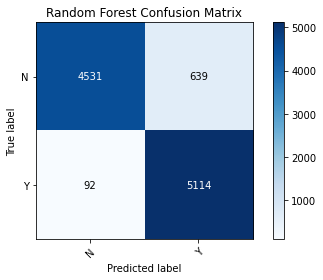

In [20]:
model, results = semi_supervised_learning(over_sampled_df, model=rf, threshold=0.7, iterations=15, algorithm='Random Forest')
# semi_supervised_learning(over_sampled_df, model=nb, threshold=0.7, iterations=15, algorithm='Naive Bayes')

In [21]:
results.to_csv('../Data/results.csv', index=False)